# V928 Tau - Ground Stellar Variations

This notebook is used to check whether the stellar variations calculated from the K2 light curve can noticeably be traced in the ground-based photometry collected for V928 Tau. It is expected that this will not be as obvious due to higher uncertainties and the probability that the stellar variation changes with time. We expect the rotation periods to stay the same, but there is likely to be starspot/phage modulation or migration that will distort the stellar variation model over time. Nevertheless we explore this here.

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from Code import ground_variation as gv
from Code import stellar_variation as sv

%matplotlib inline

## Load the Data

Load all the photometry and plot it.

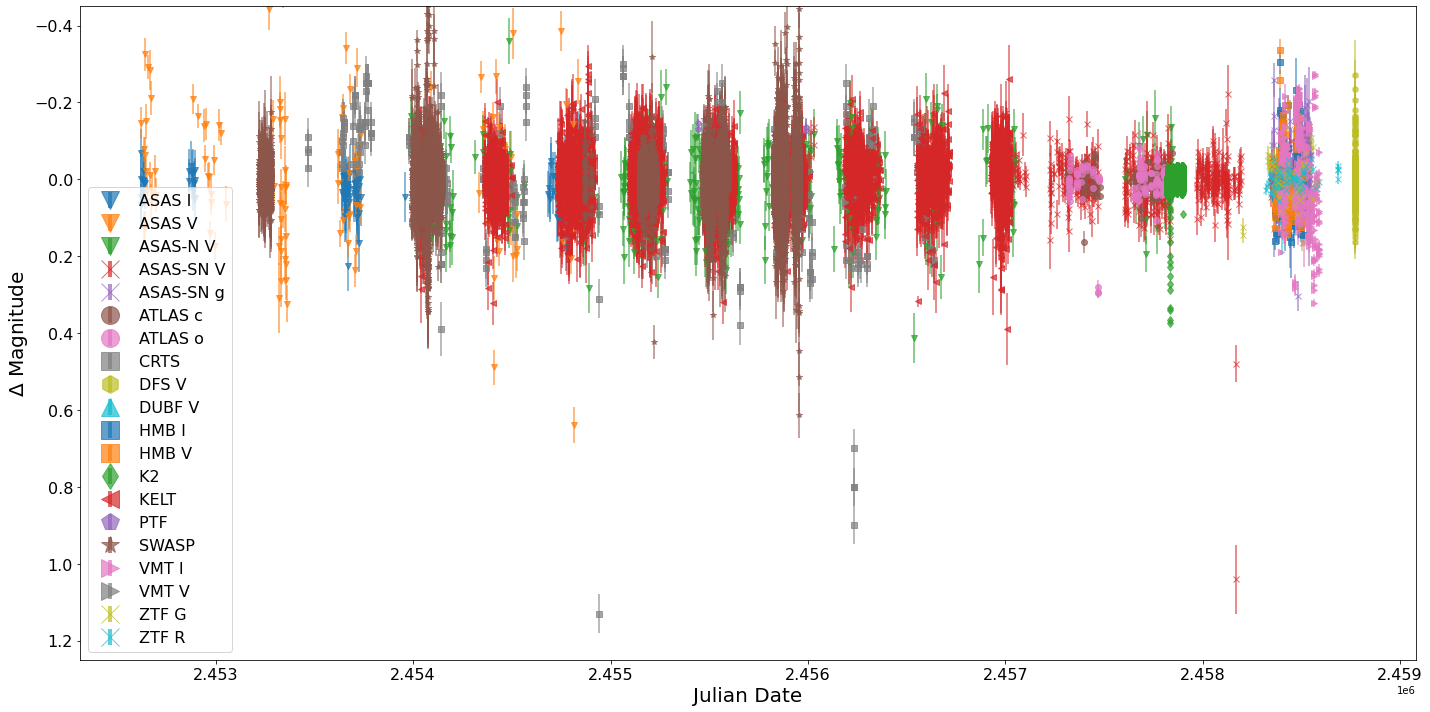

In [2]:
times, mags, errors, telescopes = gv.load_survey_data('data/photometry/all_data.txt')

gv.plot_all(times, mags, errors, telescopes, savename='plots/paper/all_phot.png')

## Load the Stellar Variation Model

Load the stellar variation model and check it against the <strong>K2</strong> light curve.

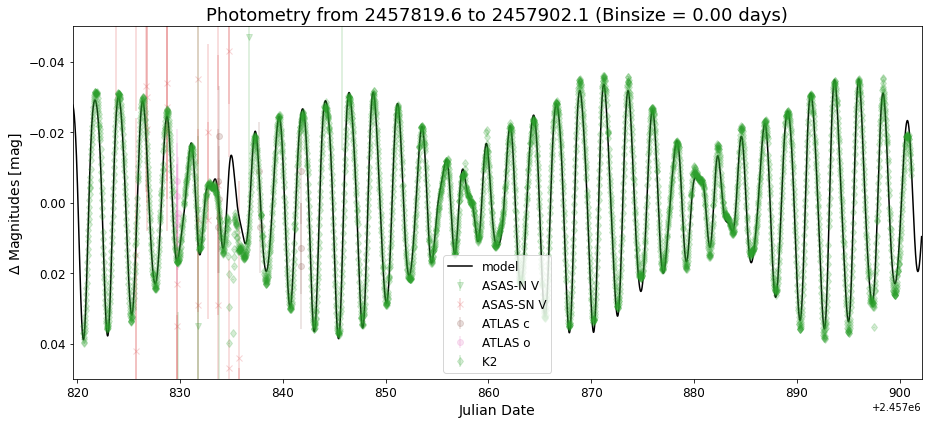

In [3]:
# extract parameters needed for the ground_stellar_variation_model
pb = np.load('models/best_fits/stellar_variation.npy')

stellar_variation = lambda P, time: sv.line(time, *P[0:2], k2_tmin) + sv.sines(time, P[2:6], P[6:10], P[10:14], k2_tmin)
ground_stellar_variation = lambda P, time: -2.5 * np.log10(stellar_variation(P, time))
k2_ind = 12
k2_tmin = times[k2_ind][0]
k2_tmax = times[k2_ind][-1]
# plot params
xlims = (k2_tmin-1, k2_tmax+1)
svm_check_args = (times, mags, errors, telescopes, ground_stellar_variation, pb)

# plot
gv.plot_part(*svm_check_args, xlim=xlims, binsize=1e-8, binned=False, ylim=(-0.05, 0.05))

## Bin and Plot the Data

Here we do several runs through the data. We bin it, and then plot in windows where we can see how well the data lines up. This section produces a lot of plots per run and thus takes quite a while and produces quite a lot of data.

In [4]:
binsizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
sigma_clips = np.array([1, 2, 3, 4, 5])
chi2_all = []
for binsize in binsizes:
    chi2_bins = []
    gv.plot_windows(*svm_check_args, ylim=(-0.1,0.1), window_size=30, binsize=binsize, unbinned_error=False)
    for sigma_clip in sigma_clips:
        chi2_bin = gv.chi2_all(*svm_check_args, binsize=binsize, sigma_clip=sigma_clip)
        chi2_bins.append(chi2_bin)
    chi2_all.append(np.array(chi2_bins))

100%|██████████| 234/234 [00:20<00:00, 11.37it/s]
